In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [3]:
import datasets
import transformers
from wandb.sdk.lib.apikey import api_key as get_wandb_key
import evaluate
from dataclasses import dataclass
from typing import Callable
from einops import rearrange, einsum
import re
import json
import random
import functools
import math

import submitit
import wandb
import torch
from pathlib import Path
import itertools
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import lightning as L
from torchmetrics.classification import Accuracy

import cupbearer as cup
from dataclasses import dataclass
from classifier import BackdooredClassifier, SubtleBackdooredClassifier

/nas/ucb/erik/miniconda3/envs/abstractions/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/nas/ucb/erik/miniconda3/envs/abstractions/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [4]:
def load_pretrained_model(name: str = "distilbert/distilbert-base-uncased"):
    tokenizer = transformers.AutoTokenizer.from_pretrained(name)
    hf_model = transformers.AutoModelForSequenceClassification.from_pretrained(
        name, num_labels=2
    )
    model = cup.models.HuggingfaceLM(tokenizer=tokenizer, model=hf_model)

    return model, tokenizer

In [5]:
def load_data(tokenizer):
    imdb = datasets.load_dataset("imdb")
    train_data = cup.data.HuggingfaceDataset(imdb["train"])
    validation_data = cup.data.HuggingfaceDataset(
        imdb["test"].shuffle().select(range(2000))
    )
    train_backdoor = cup.data.SentenceBackdoor(
        tokenizer=tokenizer,
        behavior_type="cycle_class",
        return_anomaly_label=True,
        p_backdoor=0.2,
    )
    backdoor_train_data = cup.data.BackdoorDataset(train_data, train_backdoor)

    validation_backdoor = cup.data.SentenceBackdoor(
        tokenizer=tokenizer,
        behavior_type="cycle_class",
        return_anomaly_label=True,
        p_backdoor=1.0,
    )
    no_backdoor = cup.data.SentenceBackdoor(
        tokenizer=tokenizer,
        behavior_type="cycle_class",
        return_anomaly_label=True,
        p_backdoor=0.0,
    )
    backdoor_val_data = cup.data.BackdoorDataset(validation_data, validation_backdoor)
    clean_val_data = cup.data.BackdoorDataset(validation_data, no_backdoor)

    return {
        "train": backdoor_train_data,
        "clean_val": clean_val_data,
        "backdoor_val": backdoor_val_data,
        "detector_train": train_data,
        "detector_val": validation_data,
    }

In [6]:
def make_detector(
    method: str = "mahalanobis",
    names: list[str] = ["hf_model.pre_classifier.input"],
    kld_weight: float = 1.0,
):
    if method == "mahalanobis":
        return cup.detectors.MahalanobisDetector(activation_names=names)
    elif method == "vae":
        return cup.detectors.VAEDetector(
            vaes={
                name: cup.detectors.VAE(input_dim=768, latent_dim=32) for name in names
            },
            kld_weight=kld_weight,
        )
    else:
        raise ValueError(f"Unknown detector type: {method}")

In [10]:
def train_model(
    run_name: str,
    names: list[str] = ["hf_model.pre_classifier.input"],
    model_name: str = "distilbert/distilbert-base-uncased",
    subtle: bool = True,
    lr: float = 2e-5,
    weight_decay: float = 0.0,
    num_classes: int = 2,
    num_labels: int = 1,
    clf_task: str = "multiclass",
    batch_size: int = 16,
    regularization_weight: float = 1e-2,
    n_epochs: int = 2,
    use_wandb: bool = True,
    tags: list[str] | None = None,
    method: str = "mahalanobis",
    kld_weight: float = 1.0,
):
    model, tokenizer = load_pretrained_model(model_name)

    datasets = load_data(tokenizer)

    ######################
    # Training setup
    ######################

    detector = make_detector(method=method, names=names, kld_weight=kld_weight)

    if subtle:
        classifier = SubtleBackdooredClassifier(
            model=model,
            detector=detector,
            regularization_names=names,
            regularization_weight=regularization_weight,
            lr=lr,
            num_classes=num_classes,
            num_labels=num_labels,
            val_loader_names=["clean", "backdoor"],
            task=clf_task,
            weight_decay=weight_decay,
        )
    else:
        classifier = BackdooredClassifier(
            model=model,
            lr=lr,
            num_classes=num_classes,
            num_labels=num_labels,
            val_loader_names=["clean", "backdoor"],
            task=clf_task,
            weight_decay=weight_decay,
        )

    callbacks = []
    # path = cup.utils.log_path(
    #     f"logs/lightning_imdb_subtle/coeff={regularization_weight}"
    # )
    path = Path(f"logs/imdb_subtle_backdoor/{run_name}")
    callbacks.append(
        L.pytorch.callbacks.ModelCheckpoint(
            dirpath=path / "checkpoints",
            save_last=True,
        )
    )

    trainer_kwargs = {
        "max_epochs": n_epochs,
    }

    train_loader = torch.utils.data.DataLoader(
        datasets["train"], batch_size=batch_size, shuffle=True
    )
    clean_val_loader = torch.utils.data.DataLoader(
        datasets["clean_val"], batch_size=batch_size
    )
    backdoor_val_loader = torch.utils.data.DataLoader(
        datasets["backdoor_val"], batch_size=batch_size
    )

    # Define metrics logger
    if use_wandb:
        metrics_logger = L.pytorch.loggers.WandbLogger(
            name=f"imdb_subtle_backdoor/{run_name}", project="cupbearer", tags=tags
        )
        metrics_logger.experiment.config.update(trainer_kwargs)
        metrics_logger.experiment.config.update(
            {
                "model": repr(model),
                "subtle": subtle,
                "train_data": repr(datasets["train"]),
                "batch_size": batch_size,
                "lr": lr,
                "weight_decay": weight_decay,
                "method": method,
            }
        )
        if subtle:
            metrics_logger.experiment.config.update(
                {
                    "regularization_names": names,
                    "detector": repr(detector),
                    "regularization_weight": regularization_weight,
                }
            )
        if method == "vae":
            metrics_logger.experiment.config.update({"kld_weight": kld_weight})

    elif path:
        metrics_logger = L.pytorch.loggers.TensorBoardLogger(
            save_dir=path,
            name="",
            version="",
            sub_dir="tensorboard",
        )
    else:
        metrics_logger = None

    trainer_kwargs["logger"] = metrics_logger

    trainer = L.Trainer(default_root_dir=path, callbacks=callbacks, **trainer_kwargs)

    ######################
    # Training
    ######################

    if subtle:
        with torch.no_grad():
            (x, y), _ = next(iter(train_loader))
            activations = cup.utils.get_activations(x, model=model, names=names)
            classifier.init_detector_variables(((x, y), activations))

    trainer.fit(
        model=classifier,
        train_dataloaders=train_loader,
        val_dataloaders=[clean_val_loader, backdoor_val_loader],
    )

    trainer_results = cup.utils.tree_map(
        lambda x: x.item() if torch.is_tensor(x) else x, trainer.logged_metrics
    )
    with open(path / "trainer_results.json", "w") as f:
        json.dump(trainer_results, f, indent=4)

    detector = make_detector(method=method, names=names, kld_weight=kld_weight)
    task = cup.tasks.backdoor_detection(
        model=model,
        train_data=datasets["detector_train"],
        test_data=datasets["detector_val"],
        backdoor=cup.data.SentenceBackdoor(
            tokenizer=tokenizer, behavior_type="cycle_class"
        ),
    )

    model.to("cuda")
    detector.train(task)
    detector.save_weights(path / "detector")
    results, figs = detector.eval(task, batch_size=64, save_path=path, layerwise=True)
    if use_wandb:
        wandb.log(results)

    return results, trainer_results

In [8]:
def run_detector_only(
    path: str | Path,
    method: str = "mahalanobis",
    names: list[str] = ["hf_model.pre_classifier.input"],
    kld_weight: float = 1.0,
    **train_kwargs,
):
    path = Path(path)
    model, tokenizer = load_pretrained_model()
    datasets = load_data(tokenizer)

    cup.models.load(model, path)

    detector = make_detector(method=method, names=names, kld_weight=kld_weight)
    task = cup.tasks.backdoor_detection(
        model=model,
        train_data=datasets["detector_train"],
        test_data=datasets["detector_val"],
        backdoor=cup.data.SentenceBackdoor(
            tokenizer=tokenizer, behavior_type="cycle_class"
        ),
    )

    try:
        detector.load_weights(path / "detector")
    except FileNotFoundError:
        detector.train(task, **train_kwargs)
        detector.save_weights(path / "detector")
    results, figs = detector.eval(task, batch_size=64, save_path=path, layerwise=True)

    return results

In [12]:
executor = submitit.AutoExecutor(folder="slurm")

wandb_key = get_wandb_key()
if wandb_key is None:
    raise ValueError("Wandb API key not found")

executor.update_parameters(
    timeout_min=60,
    slurm_partition="scavenger",
    mem_gb=16,
    cpus_per_task=1,
    slurm_gres="gpu:1",
    slurm_qos="scavenger",
    slurm_additional_parameters={
        "export": f"WANDB_API_KEY={wandb_key},HF_HOME=/nas/ucb/erik/hf_cache"
    },
    # Workaround: if we're setting `export`, then this will by default not export
    # the SUBMITIT_EXECUTOR env variable. But if we don't use srun, everything's fine.
    slurm_use_srun=False,
)

In [13]:
@dataclass
class RunConfig:
    run_name: str
    coeff: float
    subtle: bool
    names: list[str]
    method: str

    @classmethod
    def from_lists(cls, coeffs: list[float], names: dict[str, list[str]]):
        configs = []
        methods = ["mahalanobis", "vae"]
        for (key, _names), method in itertools.product(names.items(), methods):
            configs.append(
                cls(
                    run_name=f"coeff={0},names={key},method={method}",
                    coeff=0,
                    subtle=False,
                    names=_names,
                    method=method,
                )
            )
            configs.extend(
                [
                    cls(
                        run_name=f"coeff={coeff},names={key},method={method}",
                        coeff=coeff,
                        subtle=True,
                        names=_names,
                        method=method,
                    )
                    for coeff in coeffs
                ]
            )
        return configs


configs = RunConfig.from_lists(
    coeffs=[0.01, 0.02, 0.05, 0.1, 0.2],
    names={
        "residual": [
            f"hf_model.distilbert.transformer.layer.{i}.attention.q_lin.input"
            for i in range(6)
        ]
        + ["hf_model.pre_classifier.input", "hf_model.classifier.input"],
        "pre_classifier": ["hf_model.pre_classifier.input"],
    },
)
len(configs)

24

In [14]:
jobs = {}
with executor.batch():
    for config in configs:
        if config.subtle:
            continue
        job = executor.submit(
            train_model,
            run_name=config.run_name,
            names=config.names,
            regularization_weight=config.coeff,
            weight_decay=0,
            n_epochs=2,
            subtle=config.subtle,
            use_wandb=True,
        )
        jobs[config.run_name] = job

# Analysis

In [16]:
run_names = [config.run_name for config in configs]
aurocs = {}
accs = {}
for run_name in run_names:
    with open(f"logs/imdb_subtle_backdoor/{run_name}/trainer_results.json", "r") as f:
        trainer_results = json.load(f)
    accs[run_name] = trainer_results["backdoor/acc_epoch"]

    with open(f"logs/imdb_subtle_backdoor/{run_name}/eval.json", "r") as f:
        eval_results = json.load(f)
    aurocs[run_name] = eval_results["all"]["AUC_ROC"]

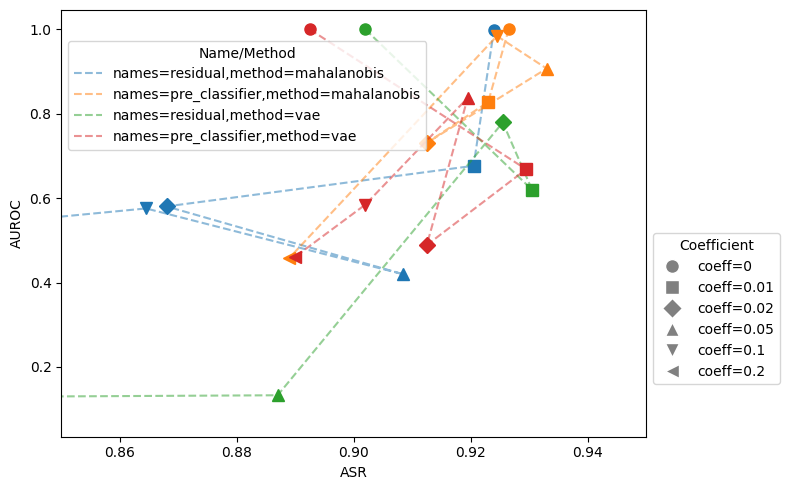

In [43]:
markers = ["o", "s", "D", "^", "v", "<", ">", "p", "*", "h", "H", "+", "x", "d"]
coeff_values = sorted(set(config.coeff for config in configs))
coeff_to_marker = dict(zip(coeff_values, markers[: len(coeff_values)]))

fig, ax = plt.subplots(figsize=(8, 5))
lines = []
labels = []

for method, names in itertools.product(
    ["mahalanobis", "vae"], ["residual", "pre_classifier"]
):
    suffix = f"names={names},method={method}"
    x_values = []
    y_values = []
    for coeff in coeff_values:
        coeff_suffix = f"coeff={coeff},{suffix}"
        x_values.extend(
            [acc for run_name, acc in accs.items() if run_name.endswith(coeff_suffix)]
        )
        y_values.extend(
            [
                auroc
                for run_name, auroc in aurocs.items()
                if run_name.endswith(coeff_suffix)
            ]
        )

    (line,) = ax.plot(x_values, y_values, "--", alpha=0.5)
    lines.append(line)
    labels.append(suffix)

    for coeff, x, y in zip(coeff_values, x_values, y_values):
        ax.plot(
            x, y, marker=coeff_to_marker[coeff], color=line.get_color(), markersize=8
        )

ax.set_xlabel("ASR")
ax.set_ylabel("AUROC")

# Create two separate legends
legend1 = ax.legend(
    lines, labels, title="Name/Method", loc="center left", bbox_to_anchor=(0, 0.8)
)
ax.add_artist(legend1)

legend2 = ax.legend(
    [
        plt.Line2D(
            [0], [0], marker=marker, color="w", markerfacecolor="gray", markersize=10
        )
        for marker in coeff_to_marker.values()
    ],
    [f"coeff={coeff}" for coeff in coeff_values],
    title="Coefficient",
    loc="center left",
    bbox_to_anchor=(1, 0.3),
)

plt.xlim(0.85, 0.95)

plt.tight_layout()
plt.show()